In [34]:
import json
from itertools import product
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from astropy.time import Time
from sherpa.astro.io import read_arf, read_rmf
from sherpa.astro.instrument import RSPModelNoPHA
from sherpa.astro.utils import calc_model_sum
from sherpa.astro.xspec import XSpowerlaw, XSphabs, XSTBabs, XSwabs

plt.style.use("Solarize_Light2")


def calc_ecf(rsp_model, elo, ehi, abscorr=False):
    rate = rsp_model(0)

    if abscorr:
        flux_model = rsp_model.model.parts[1]
    else:
        flux_model = rsp_model.model

    e = 0.5 * (rsp_model.rmf.e_min + rsp_model.rmf.e_max)
    flux = e * flux_model(rsp_model.rmf.e_min, rsp_model.rmf.e_max) << u.keV / u.s / u.cm**2 
    flux = flux.to(u.erg / u.s / u.cm**2).value
    
    mask_eband = np.logical_and(rsp_model.rmf.e_min >= elo, rsp_model.rmf.e_max <= ehi)
    
    return rate[mask_eband].sum() / flux[mask_eband].sum() / 1e11


ecf_4xmm = {
    "PN": {
        # thin / medium / thick
        1: [9.52, 8.37, 5.11],  # 0.2-0.5 keV
        2: [8.12, 7.87, 6.05],  # 0.5-1.0 keV 
        3: [5.87, 5.77, 4.99],  # 1.0-2.0 keV 
        4: [1.95, 1.93, 1.83],  # 2.0-4.5 keV 
        5: [0.58, 0.58, 0.57],  # 4.5-12.0 keV 
        6: [7.39, 7.01, 5.41],  # 0.2-2.0 keV
        7: [1.11, 1.10, 1.06],  # 2.0-12.0 keV 
        8: [3.32, 3.19, 2.59],  # 0.2-12.0 keV
        9: [4.56, 4.46, 3.76],  # 0.5-4.5 keV
    },
    "M1": {
        1: [1.73, 1.53, 1.00],
        2: [1.75, 1.70, 1.38],
        3: [2.04, 2.01, 1.79],
        4: [0.74, 0.73, 0.70],
        5: [0.15, 0.15, 0.14],
        6: [1.93, 1.85, 1.53],
        7: [0.38, 0.38, 0.37],
        8: [0.93, 0.90, 0.78],        
        9: [1.38, 1.36, 1.20],
    },
    "M2": {
        1: [1.73, 1.52, 0.99],
        2: [1.76, 1.71, 1.39],
        3: [2.04, 2.01, 1.79],
        4: [0.74, 0.73, 0.70],
        5: [0.15, 0.15, 0.15],
        6: [1.93, 1.85, 1.53],
        7: [0.39, 0.39, 0.37],
        8: [0.94, 0.91, 0.78],        
        9: [1.39, 1.36, 1.21],
    }
}



filters = ("Thin", "Medium", "Thick")
cameras = ("PN", "M1", "M2")

ebands = {
    1: (0.2, 0.5),
    2: (0.5, 1.0),
    3: (1.0, 2.0),
    4: (2.0, 4.5),
    5: (4.5, 12.0),
    6: (0.2, 2.0),
    7: (2.0, 12.0),
    8: (0.2, 12.0),
    9: (0.5, 4.5),
    "SOFT": (0.5, 2.0),
    "HARD": (2.0, 10.0),
}

pn_epochs = {
    "e1": ("1999-12-10", "2007-01-01"),
    "e2": ("2007-01-01", "2014-01-01"),
    "e3": ("2014-01-01", "2021-01-01"),
    "e4": ("2021-01-01 ", None),
}

mos_epochs = {
    "e1": ("1999-12-10", "2000-10-03"),
    "e2": ("2000-10-03", "2001-04-22"),
    "e3": ("2001-04-22", "2001-11-07"),
    "e4": ("2001-11-07", "2002-05-26"),
    "e5": ("2002-05-26", "2002-11-05"),
    "e6": ("2002-11-05", "2004-01-14"),
    "e7": ("2004-01-14", "2005-02-14"),
    "e8": ("2005-02-14", "2006-03-22"),
    "e9": ("2006-03-22", "2007-04-24"),
    "e10": ("2007-04-24", "2008-05-28"),
    "e11": ("2008-05-28", "2009-07-01"),
    "e12": ("2009-07-01", "2010-08-03"),
    "e13": ("2010-08-03", "2011-09-07"),
    "e14": ("2011-09-07", "2013-04-27"),
    "e15": ("2013-04-27", "2014-12-16"),
    "e16": ("2014-12-16", "2016-08-05"),
    "e17": ("2016-08-05", "2018-03-26"),
    "e18": ("2018-03-26", "2019-11-14"),
    "e19": ("2019-11-14", None),
}

pn_modes = ("ff", "ef", "sw", "lw")
mos_modes = ("im",)

data_path = Path("data", "xmm")

In [2]:
# Source model, as in Rossen+2016
po = XSpowerlaw("po")
po.PhoIndex = 1.7

galabs = XSphabs("galabs")
# galabs = XSwabs("galabs")
# galabs = XSTBabs("galabs")
galabs.nH = 3e20 / 1e22

model = galabs * po

In [4]:
arfs_path = data_path / "arfs"
rmfs_path = data_path / "rmfs"

lognhs = np.linspace(19, 22, num=31)
gammas = np.linspace(1.4, 2.2, num=9)

ecf = {
    "lognh": lognhs.tolist(),
    "gamma": gammas.tolist(),
}
for camera in cameras:
    ecf[camera] = {}

    if camera == "PN":
        rmf_template = "e{}_{}_{}20_{}Y9_v21.0.rmf"
        epochs = pn_epochs
        modes = pn_modes
    else:
        rmf_template = "{}_{}_{}_pall_o.rmf"
        epochs = mos_epochs
        modes = mos_modes
        
    for epoch in epochs:
        ecf[camera][epoch] = {}

        for mode in modes:
            ecf[camera][epoch][mode] = {}

            for eband, (elo, ehi) in ebands.items():
                ecf[camera][epoch][mode][eband] = {}

                if eband == 1 and camera == "PN":
                    rmf_patterns = "s"
                    arf_patterns = "_singles"
                else:
                    rmf_patterns = "sd"
                    arf_patterns = ""
                
                for filter in filters:
                    print(camera, epoch, mode, eband, filter)
                    rmf = read_rmf(str(rmfs_path / rmf_template.format(camera.lower(), epoch, mode, rmf_patterns)))
                    arf = read_arf(str(arfs_path / f"{filter}_{camera}{arf_patterns}.arf"))
                    rsp_model = RSPModelNoPHA(arf, rmf, model)

                    model_ecfs = []
                    for lognh, gamma in product(lognhs, gammas):
                        rsp_model.pars[0].val = 10**lognh / 1e22
                        rsp_model.pars[1].val = gamma

                        model_ecfs.append(calc_ecf(rsp_model, elo, ehi))

                    ecf[camera][epoch][mode][eband][filter] = np.reshape(model_ecfs, (len(lognhs), len(gammas))).tolist()


with open(data_path / "ecfs.json", "w") as fp:
    json.dump(ecf, fp, indent=4)

PN e1 ff 1 Thin
PN e1 ff 1 Medium
PN e1 ff 1 Thick
PN e1 ff 2 Thin
PN e1 ff 2 Medium
PN e1 ff 2 Thick
PN e1 ff 3 Thin
PN e1 ff 3 Medium
PN e1 ff 3 Thick
PN e1 ff 4 Thin
PN e1 ff 4 Medium
PN e1 ff 4 Thick
PN e1 ff 5 Thin
PN e1 ff 5 Medium
PN e1 ff 5 Thick
PN e1 ff 6 Thin
PN e1 ff 6 Medium
PN e1 ff 6 Thick
PN e1 ff 7 Thin
PN e1 ff 7 Medium
PN e1 ff 7 Thick
PN e1 ff 8 Thin
PN e1 ff 8 Medium
PN e1 ff 8 Thick
PN e1 ff 9 Thin
PN e1 ff 9 Medium
PN e1 ff 9 Thick
PN e1 ff SOFT Thin
PN e1 ff SOFT Medium
PN e1 ff SOFT Thick
PN e1 ff HARD Thin
PN e1 ff HARD Medium
PN e1 ff HARD Thick
PN e1 ef 1 Thin
PN e1 ef 1 Medium
PN e1 ef 1 Thick
PN e1 ef 2 Thin
PN e1 ef 2 Medium
PN e1 ef 2 Thick
PN e1 ef 3 Thin
PN e1 ef 3 Medium
PN e1 ef 3 Thick
PN e1 ef 4 Thin
PN e1 ef 4 Medium
PN e1 ef 4 Thick
PN e1 ef 5 Thin
PN e1 ef 5 Medium
PN e1 ef 5 Thick
PN e1 ef 6 Thin
PN e1 ef 6 Medium
PN e1 ef 6 Thick
PN e1 ef 7 Thin
PN e1 ef 7 Medium
PN e1 ef 7 Thick
PN e1 ef 8 Thin
PN e1 ef 8 Medium
PN e1 ef 8 Thick
PN e1 ef 9 Th

/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e1 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e2 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e3 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e4 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e5 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e6 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e7 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e8 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e9 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e10 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e11 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e12 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e13 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e14 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e15 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e16 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e17 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e18 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M1 e19 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e1 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e2 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e3 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e4 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e5 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e6 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e7 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e8 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e9 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e10 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e11 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e12 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e13 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e14 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e15 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e16 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e17 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e18 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im 1 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im 1 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im 1 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im 2 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im 2 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im 2 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im 3 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im 3 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im 3 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im 4 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im 4 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im 4 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im 5 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im 5 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im 5 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im 6 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im 6 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im 6 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im 7 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im 7 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im 7 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im 8 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im 8 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im 8 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im 9 Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im 9 Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im 9 Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im SOFT Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im SOFT Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im SOFT Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im HARD Thin


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im HARD Medium


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


M2 e19 im HARD Thick


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


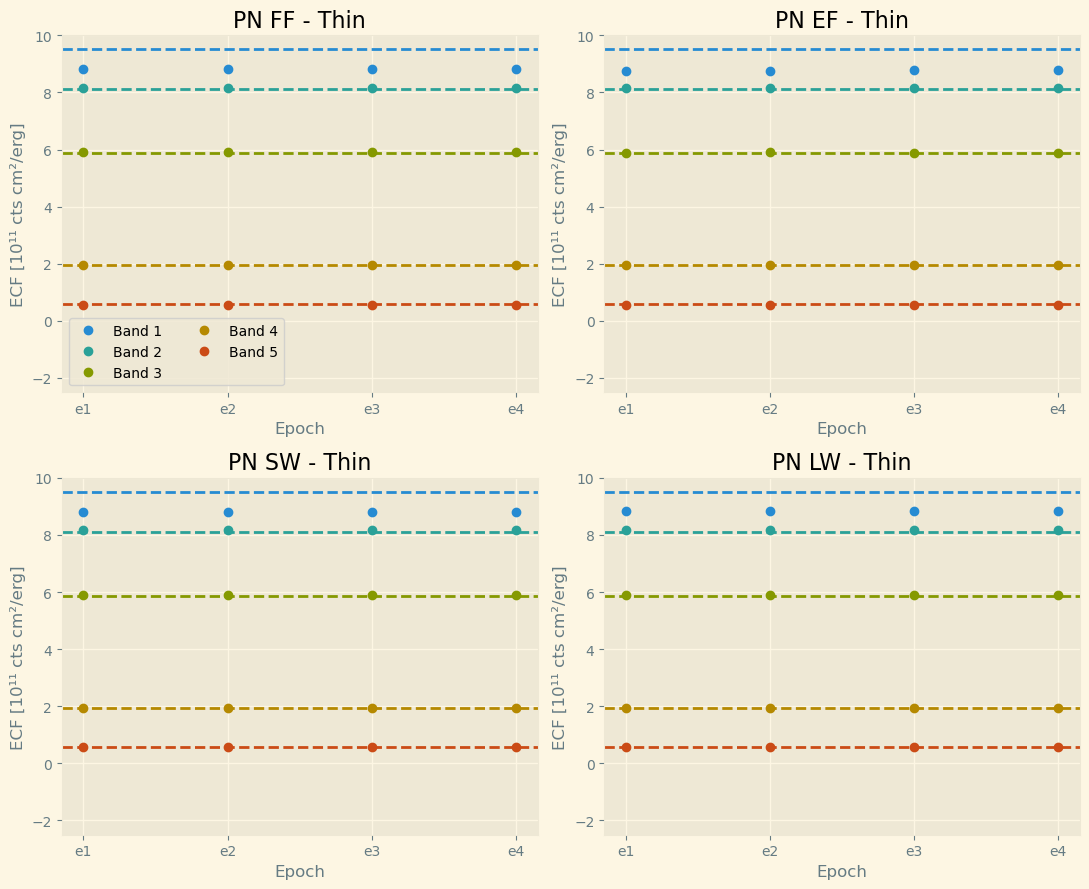

In [56]:
filter = "Thin"
idx_lognh = 15  # ~3e20
idx_gamma = 3   # 1.7


plt.figure(figsize=(11,9))

ax = None
for i, mode in enumerate(pn_modes, start=1):

    ax = plt.subplot(2,2,i, sharey=ax)
    plt.title(f"PN {mode.upper()} - {filter}")

    for eband in range(1, 6):
        cecf = [ecf["PN"][epoch][mode][eband][filter][idx_lognh][idx_gamma] for epoch in pn_epochs]

        vals, = plt.plot(pn_epochs.keys(), cecf, "o", label=f"Band {eband}")
        plt.axhline(ecf_4xmm["PN"][eband][idx_filter], ls="--", color=vals.get_color())

        # max_diff = np.max(cecf) - np.min(cecf)
        # print(mode, eband, 100*np.std(cecf)/np.mean(cecf), 100*max_diff/np.mean(cecf))

    plt.xlabel("Epoch")
    plt.ylabel("ECF [10¹¹ cts cm²/erg]")

    if i == 1:
        plt.legend(ncol=2)

plt.ylim(-2.5, 10)

plt.tight_layout()
plt.show()

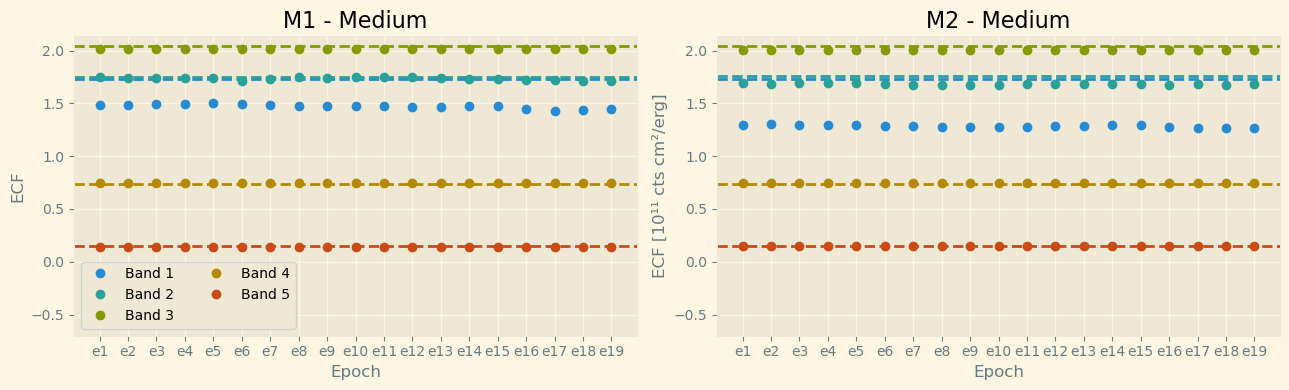

In [59]:
filter = "Medium"
idx_lognh = 15  # ~3e20
idx_gamma = 3   # 1.7


plt.figure(figsize=(13,4))

ax = plt.subplot(121)
plt.title(f"M1 - {filter}")

for eband in range(1, 6):
    cecf = [ecf["M1"][epoch]["im"][eband][filter][idx_lognh][idx_gamma] for epoch in mos_epochs]

    vals, = plt.plot(mos_epochs.keys(), cecf, "o", label=f"Band {eband}")
    plt.axhline(ecf_4xmm["M1"][eband][idx_filter], ls="--", color=vals.get_color())

    # max_diff = np.max(cecf) - np.min(cecf)
    # print("m1", eband, 100*np.std(cecf)/np.mean(cecf), 100*max_diff/np.mean(cecf))

plt.legend(ncol=2)
plt.xlabel("Epoch")
plt.ylabel("ECF")


plt.subplot(122, sharey=ax)
plt.title(f"M2 - {filter}")

for eband in range(1, 6):
    cecf = [ecf["M2"][epoch]["im"][eband][filter][idx_lognh][idx_gamma] for epoch in mos_epochs]

    vals, = plt.plot(mos_epochs.keys(), cecf, "o", label=f"Band {eband}")
    plt.axhline(ecf_4xmm["M2"][eband][idx_filter], ls="--", color=vals.get_color())

    # max_diff = np.max(cecf) - np.min(cecf)
    # print("m2", eband, 100*np.std(cecf)/np.mean(cecf), 100*max_diff/np.mean(cecf))

plt.ylim(-0.7)
plt.xlabel("Epoch")
plt.ylabel("ECF [10¹¹ cts cm²/erg]")


plt.tight_layout()
plt.show()

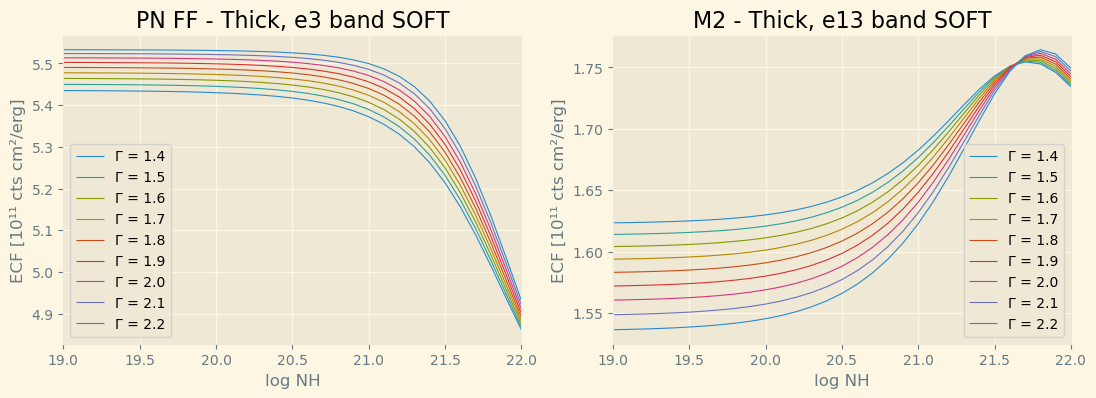

In [47]:
filter = "Thick"
band = "SOFT"

plt.figure(figsize=(13,4))

plt.subplot(121)
plt.title(f"PN FF - {filter}, e3 band {band}")

for i, gamma in enumerate(ecf["gamma"]):
    cecf = [ecf["PN"]["e3"]["ff"][band][filter][idx_lognh][i] for idx_lognh, _ in enumerate(ecf["lognh"])]
    plt.plot(ecf["lognh"], cecf, lw=0.8, label=f"Γ = {gamma:.1f}")

plt.legend()

plt.xlim(19, 22)
plt.xlabel("log NH")
plt.ylabel("ECF [10¹¹ cts cm²/erg]")


plt.subplot(122)
plt.title(f"M2 - {filter}, e13 band {band}")

for i, gamma in enumerate(ecf["gamma"]):
    cecf = [ecf["M2"]["e13"]["im"][band][filter][idx_lognh][i] for idx_lognh, _ in enumerate(ecf["lognh"])]
    plt.plot(ecf["lognh"], cecf, lw=0.8, label=f"Γ = {gamma:.1f}")

plt.legend()

plt.xlim(19, 22)
plt.xlabel("log NH")
plt.ylabel("ECF [10¹¹ cts cm²/erg]")

plt.show()

In [51]:
# arfs_path = data_path / "arfs"
# rmfs_path = data_path / "rmfs"

# lognhs = np.linspace(19, 22, num=31)
# gammas = np.linspace(1.4, 2.2, num=9)

abscorr_ecf = {
    "lognh": lognhs.tolist(),
    "gamma": gammas.tolist(),
}
for camera in cameras:
    abscorr_ecf[camera] = {}

    if camera == "PN":
        rmf_template = "e{}_{}_{}20_{}Y9_v21.0.rmf"
        epochs = pn_epochs
        modes = pn_modes
    else:
        rmf_template = "{}_{}_{}_pall_o.rmf"
        epochs = mos_epochs
        modes = mos_modes
        
    for epoch in epochs:
        abscorr_ecf[camera][epoch] = {}

        for mode in modes:
            abscorr_ecf[camera][epoch][mode] = {}

            for eband, (elo, ehi) in ebands.items():
                abscorr_ecf[camera][epoch][mode][eband] = {}

                if eband == 1 and camera == "PN":
                    rmf_patterns = "s"
                    arf_patterns = "_singles"
                else:
                    rmf_patterns = "sd"
                    arf_patterns = ""
                
                for filter in filters:
                    print(camera, epoch, mode, eband, filter, end="\r")
                    rmf = read_rmf(str(rmfs_path / rmf_template.format(camera.lower(), epoch, mode, rmf_patterns)))
                    arf = read_arf(str(arfs_path / f"{filter}_{camera}{arf_patterns}.arf"))
                    rsp_model = RSPModelNoPHA(arf, rmf, model)

                    model_ecfs = []
                    for lognh, gamma in product(lognhs, gammas):
                        rsp_model.pars[0].val = 10**lognh / 1e22
                        rsp_model.pars[1].val = gamma

                        model_ecfs.append(calc_ecf(rsp_model, elo, ehi, abscorr=True))

                    abscorr_ecf[camera][epoch][mode][eband][filter] = np.reshape(model_ecfs, (len(lognhs), len(gammas))).tolist()


with open(data_path / "abscorr_ecfs.json", "w") as fp:
    json.dump(abscorr_ecf, fp, indent=4)

/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m1_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M1.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e1_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e2_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e3_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e4_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e5_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e6_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e7_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e8_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e9_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e10_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e11_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e12_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e13_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e14_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e15_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e16_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e17_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e18_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thin_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Medium_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the RMF 'data/xmm/rmfs/m2_e19_im_pall_o.rmf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)
/opt/conda/envs/sherpabxa/lib/python3.8/site-packages/sherpa/astro/data.py:952: UserWarning: The minimum ENERG_LO in the ARF 'data/xmm/arfs/Thick_M2.arf' was 0 and has been replaced by 1e-10
  warnings.warn(wmsg)


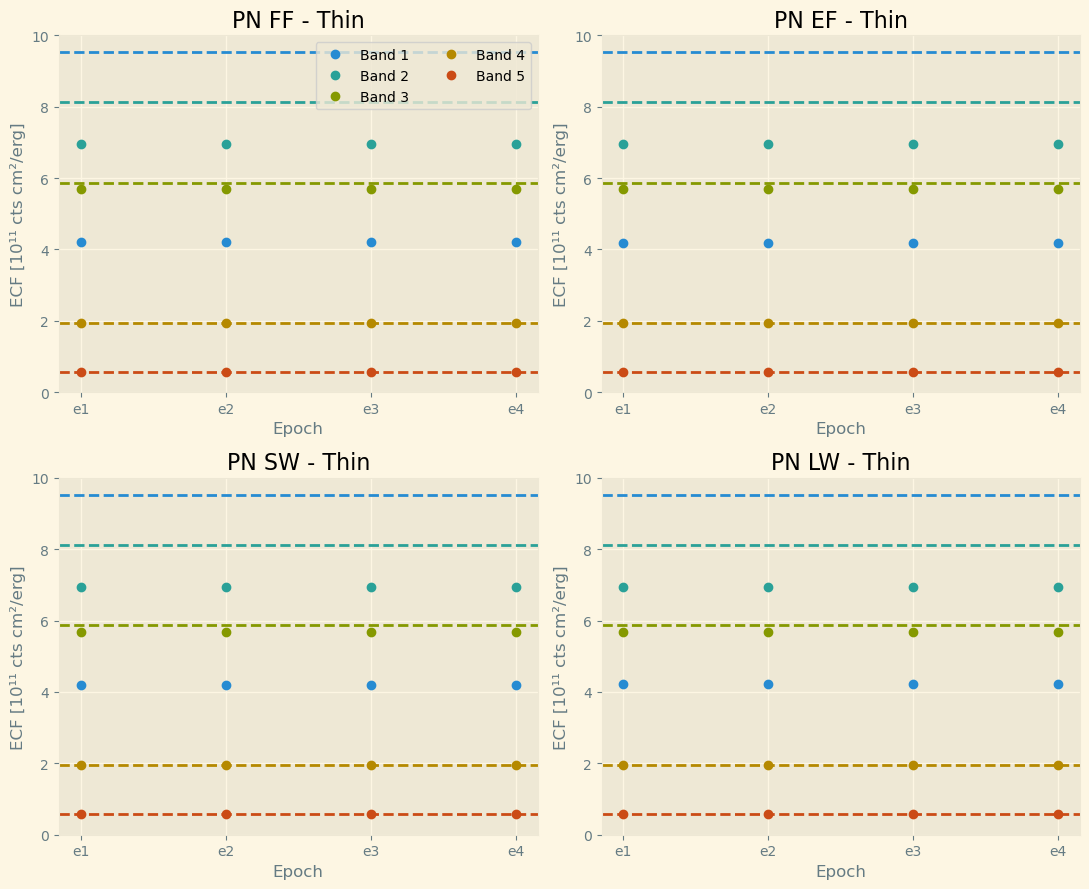

In [53]:
filter = "Thin"
idx_lognh = 15  # ~3e20
idx_gamma = 3   # 1.7


plt.figure(figsize=(11,9))

ax = None
for i, mode in enumerate(pn_modes, start=1):

    ax = plt.subplot(2,2,i, sharey=ax)
    plt.title(f"PN {mode.upper()} - {filter}")

    for eband in range(1, 6):
        cecf = [abscorr_ecf["PN"][epoch][mode][eband][filter][idx_lognh][idx_gamma] for epoch in pn_epochs]

        vals, = plt.plot(pn_epochs.keys(), cecf, "o", label=f"Band {eband}")
        plt.axhline(ecf_4xmm["PN"][eband][idx_filter], ls="--", color=vals.get_color())

        # max_diff = np.max(cecf) - np.min(cecf)
        # print(mode, eband, 100*np.std(cecf)/np.mean(cecf), 100*max_diff/np.mean(cecf))

    plt.xlabel("Epoch")
    plt.ylabel("ECF [10¹¹ cts cm²/erg]")

    if i == 1:
        plt.legend(ncol=2)

plt.ylim(0, 10)

plt.tight_layout()
plt.show()

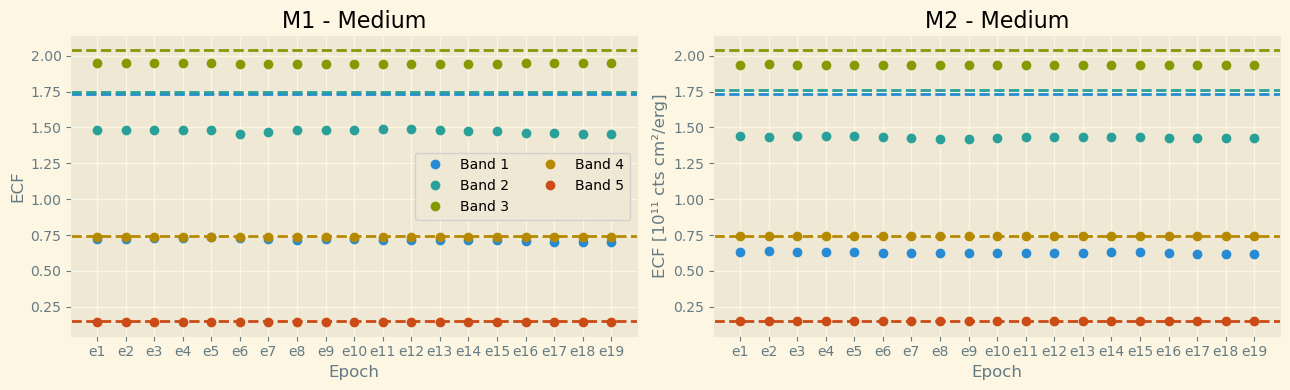

In [61]:
filter = "Medium"
idx_lognh = 15  # ~3e20
idx_gamma = 3   # 1.7


plt.figure(figsize=(13,4))

ax = plt.subplot(121)
plt.title(f"M1 - {filter}")

for eband in range(1, 6):
    cecf = [abscorr_ecf["M1"][epoch]["im"][eband][filter][idx_lognh][idx_gamma] for epoch in mos_epochs]

    vals, = plt.plot(mos_epochs.keys(), cecf, "o", label=f"Band {eband}")
    plt.axhline(ecf_4xmm["M1"][eband][idx_filter], ls="--", color=vals.get_color())

    # max_diff = np.max(cecf) - np.min(cecf)
    # print("m1", eband, 100*np.std(cecf)/np.mean(cecf), 100*max_diff/np.mean(cecf))

plt.legend(ncol=2)
plt.xlabel("Epoch")
plt.ylabel("ECF")


plt.subplot(122, sharey=ax)
plt.title(f"M2 - {filter}")

for eband in range(1, 6):
    cecf = [abscorr_ecf["M2"][epoch]["im"][eband][filter][idx_lognh][idx_gamma] for epoch in mos_epochs]

    vals, = plt.plot(mos_epochs.keys(), cecf, "o", label=f"Band {eband}")
    plt.axhline(ecf_4xmm["M2"][eband][idx_filter], ls="--", color=vals.get_color())

    # max_diff = np.max(cecf) - np.min(cecf)
    # print("m2", eband, 100*np.std(cecf)/np.mean(cecf), 100*max_diff/np.mean(cecf))

# plt.ylim(-0.7)
plt.xlabel("Epoch")
plt.ylabel("ECF [10¹¹ cts cm²/erg]")


plt.tight_layout()
plt.show()

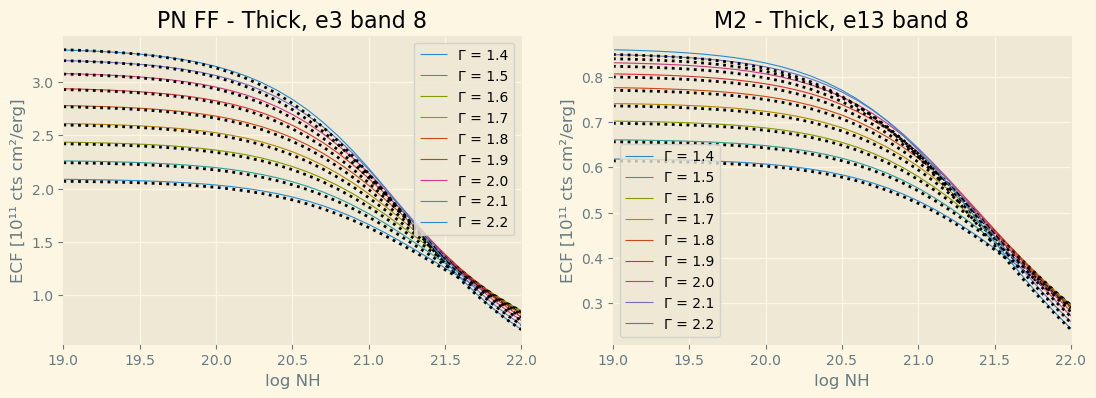

In [92]:
rapidxmm_ecf = np.load(data_path / "xmmpype_ecf.npy", allow_pickle=True).item()

filter = "Thick"
band = 8
rapidxmm_band = "full"


plt.figure(figsize=(13,4))

plt.subplot(121)
plt.title(f"PN FF - {filter}, e3 band {band}")

for i, gamma in enumerate(abscorr_ecf["gamma"]):
    cecf = [abscorr_ecf["PN"]["e3"]["ff"][band][filter][idx_lognh][i] for idx_lognh, _ in enumerate(abscorr_ecf["lognh"])]
    oecf = [rapidxmm_ecf[filter.lower()][rapidxmm_band]["PN"]["ecf"][idx_lognh][i]/1e11 for idx_lognh, _ in enumerate(abscorr_ecf["lognh"])]
    plt.plot(abscorr_ecf["lognh"], cecf, lw=0.8, label=f"Γ = {gamma:.1f}")
    plt.plot(abscorr_ecf["lognh"], oecf, color="k", ls=":")

plt.legend()

plt.xlim(19, 22)
plt.xlabel("log NH")
plt.ylabel("ECF [10¹¹ cts cm²/erg]")


plt.subplot(122)
plt.title(f"M2 - {filter}, e13 band {band}")

for i, gamma in enumerate(abscorr_ecf["gamma"]):
    cecf = [abscorr_ecf["M2"]["e13"]["im"][band][filter][idx_lognh][i] for idx_lognh, _ in enumerate(abscorr_ecf["lognh"])]
    oecf = [rapidxmm_ecf[filter.lower()][rapidxmm_band]["M2"]["ecf"][idx_lognh][i]/1e11 for idx_lognh, _ in enumerate(abscorr_ecf["lognh"])]
    plt.plot(abscorr_ecf["lognh"], cecf, lw=0.8, label=f"Γ = {gamma:.1f}")
    plt.plot(abscorr_ecf["lognh"], oecf, color="k", ls=":")
    
plt.legend()

plt.xlim(19, 22)
plt.xlabel("log NH")
plt.ylabel("ECF [10¹¹ cts cm²/erg]")

plt.show()